<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling as pp
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
ls

Ames Real Estate Data.xlsx          final data manipulations.ipynb
Ames_dataset.xlsx                   fixed_col.csv
Data manipulation.ipynb             housing.csv*
Project-03-Q2.ipynb                 lat_long_test.csv
README.md*                          lat_long_train.csv
Tbl_DataExportSpec.xls              model_predicted.csv
Untitled.ipynb                      new_full_set.csv
ames.csv                            new_housing.csv
ames.twb                            nfs2 - nfs2.csv
ames_R.csv                          nfs2.csv
ames_edit.csv                       project-03-Q1.ipynb*
chromedriver/                       project-03-Q3.ipynb
data_description.txt*               project-03-webscrape_attempt.ipynb
df1.csv                             test.csv
df2.csv                             test_data - df2.csv
df3.csv                             train.csv
df4.csv                             train_data - df1.csv
dfm.csv


In [3]:
'''
Here the data was loaded
'''
ames = pd.read_csv('./ames.csv')

In [4]:
'''
Here I checked the shape of the dataframe
'''
ames.shape

(1459, 85)

In [5]:
'''
Here I assess the column names, and working in concert with the data dictionary, try to identify the meaning of 
as many headings as possible 
'''
ames.columns

Index(['Unnamed: 0', 'Id', 'Prop_Addr', 'Latitude', 'Longitude', 'MSSubClass',
       'MSZoning', 'LotFrontage', 'LotArea_y', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars',

In [6]:
'''
Here I dropped the 'Unmamed: 0' column, which appears to be a repeat of the index column
'''
ames = ames.drop(['Unnamed: 0'], axis=1)

In [7]:
'''
Here I wanted to look at the first few values, and see any potential issues in the dataframe
'''
ames.head()

,Id,Prop_Addr,Latitude,Longitude,MSSubClass,MSZoning,LotFrontage,LotArea_y,Street,Alley,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold_y,YrSold,SaleType,SaleCondition,SalePrice_y
0,1,821 MILLER AVE,42.015396,-93.686978,60,RL,65.0,8450,Pave,NaN,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,2124 TORREY PINES RD,42.043182,-93.645305,20,RL,80.0,9600,Pave,NaN,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,718 WILDER BLVD,42.015930,-93.688636,60,RL,68.0,11250,Pave,NaN,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,504 ASH AVE,42.017729,-93.644027,70,RL,60.0,9550,Pave,NaN,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,3127 ALMOND RD,42.055872,-93.653959,60,RL,84.0,14260,Pave,NaN,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
'''
Always a good idea to check the end of the dataframe as well in cae there are any cumulitive rows
'''
ames.tail()

,Id,Prop_Addr,Latitude,Longitude,MSSubClass,MSZoning,LotFrontage,LotArea_y,Street,Alley,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold_y,YrSold,SaleType,SaleCondition,SalePrice_y
1454,1456,2409 WELBECK DR,42.058161,-93.641823,60,RL,62.0,7917,Pave,NaN,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1455,1457,3309 CLINTON CT,42.054940,-93.637003,20,RL,85.0,13175,Pave,NaN,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1456,1458,916 GASKILL DR,42.014331,-93.642489,70,RL,66.0,9042,Pave,NaN,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1457,1459,914 MURRAY DR,42.038980,-93.623405,20,RL,68.0,9717,Pave,NaN,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1458,1460,208 TODD CIR,42.020845,-93.677130,20,RL,75.0,9937,Pave,NaN,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [9]:
'''
Here I look to remove any non-residential properties from the dataframe. Residential categories are kept in 'MSZoning'
wit C representing commercial real estate
'''
ames['MSZoning'].value_counts()

RL         1152
RM          219
FV           65
RH           14
C (all)       9
Name: MSZoning, dtype: int64

In [10]:
'''
Here I remove all rows that have the designation 'C (all)'. I am choosing the keep the rest of the MSZoning categories
as I believe they may be linked to house sale prices. I reprint the dataframe shape to confirm that the rows have been
removed.
'''
ames = ames[ames.MSZoning != 'C (all)']
ames.shape

(1450, 84)

In [11]:
'''
Here we can see the number of null values in each feature.
'''

null_count = ames.isnull().sum()
null_count[null_count > 0]

LotFrontage      259
Alley           1362
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      684
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1443
Fence           1173
MiscFeature     1398
dtype: int64

In [12]:
'''
Here I remove the row that is missing from Electrical
'''
ames.dropna(subset=['Electrical'], inplace=True)

In [13]:
'''
Here I replace all of the Nan values with 0. I manually went through the data dictionary first to confirm 
that the null values were indicative of the feature being absent, accordingly a one size fits all approach is 
acceptable
'''

for column in ames:
    if ames[column].isnull().sum()!=0:
        print(column, 'has been filled')
        ames[column].fillna(0, inplace=True)
    else:
        pass

LotFrontage has been filled
Alley has been filled
MasVnrType has been filled
MasVnrArea has been filled
BsmtQual has been filled
BsmtCond has been filled
BsmtExposure has been filled
BsmtFinType1 has been filled
BsmtFinType2 has been filled
FireplaceQu has been filled
GarageType has been filled
GarageYrBlt has been filled
GarageFinish has been filled
GarageQual has been filled
GarageCond has been filled
PoolQC has been filled
Fence has been filled
MiscFeature has been filled


In [14]:
'''
Confirm all nulls have been removed
'''
null_count = ames.isnull().sum()
null_count[null_count > 0]

Series([], dtype: int64)

In [15]:
'''
Here I remove all columns that have more than 70% 0 values.
'''

for column in ames:
    if ((ames[column] == 0).sum()/len(ames)) >= 0.7:
        print(column, 'has been deleted')
        ames.drop([column], axis=1, inplace=True)
    else:
        pass

Alley has been deleted
BsmtFinSF2 has been deleted
LowQualFinSF has been deleted
BsmtHalfBath has been deleted
EnclosedPorch has been deleted
3SsnPorch has been deleted
ScreenPorch has been deleted
PoolArea has been deleted
PoolQC has been deleted
Fence has been deleted
MiscFeature has been deleted
MiscVal has been deleted


In [16]:
'''
Here I check how the who dataset shape has been altered
'''
ames.shape

(1449, 72)

In [17]:
'''
Here I run the profile report from pandas profiling. This report returns a high level summary, where any 
concerns with the dataframe are highlighted
'''
#pp.ProfileReport(ames)

'\nHere I run the profile report from pandas profiling. This report returns a high level summary, where any \nconcerns with the dataframe are highlighted\n'

In [18]:
'''
Here I check all of the column names remaining in the dataset
'''

ames.columns

Index(['Id', 'Prop_Addr', 'Latitude', 'Longitude', 'MSSubClass', 'MSZoning',
       'LotFrontage', 'LotArea_y', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

In [19]:
'''
As the Utilies category has only two unique values, with only 1 row not being all public utilities, I am going to 
delete the row with NoSewa then remove the whole column.
'''
ames = ames[ames.Utilities != 'NoSeWa']
ames = ames.drop(['Utilities'], axis=1)

In [20]:
'''
As Street only contains two distinct results, with only 4 points in Gravel, I have decided to delete the Gravel rows
and column.
'''
ames = ames[ames.Street != 'Grvl']
ames = ames.drop(['Street'], axis=1)

In [21]:
'''
As MSSubclass is a combination of HouseStyle, BuildingType and YearBuilt I have decided to remove the column.
'''
ames.drop(['MSSubClass'], axis=1, inplace=True)


In [22]:
'''
Confirm deletion of rows by looking at how the shape has changed
'''
ames.shape


(1444, 69)

In [23]:
'''
As some of the categorical variables are representative of a likert scale, can convert the terms into integers.
Those with consistent scale have been changed via the for loop, those with inconsistent scale have been changed more
manually
'''
likert = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 
           'GarageQual', 'GarageCond']

for column in likert:
    ames[column] = [5 if row == 'Ex' else 4 if row == 'Gd' else 3 if row == 'TA' else 2 if row == 'Fa' else 1 if 
                     row == 'Po' else 0 for row in ames[column]]

ames['BsmtExposure'] = [4 if row == 'Gd' else 3 if row == 'Av' else 2 if row == 'Mn' else 1 if row == 'No' else 
                        0 for row in ames['BsmtExposure']]

ames['BsmtFinType1'] = [6 if row == 'GLQ' else 5 if row == 'ALQ' else 4 if row == 'BLQ' else 3 if row == 'Rec' else 
                        2 if row == 'LwQ' else 1 if row == 'Unf' else 0 for row in ames['BsmtFinType1']]

ames['BsmtFinType2'] = [6 if row == 'GLQ' else 5 if row == 'ALQ' else 4 if row == 'BLQ' else 3 if row == 'Rec' else 
                        2 if row == 'LwQ' else 1 if row == 'Unf' else 0 for row in ames['BsmtFinType2']]

ames['GarageFinish'] = [3 if row == 'Fin' else 2 if row == 'RFn' else 1 if row == 'Unf' else 0 
                        for row in ames['GarageFinish']]

#And for Central Air we can convert it into a boolean, 1 for Yes, 0 for No.
              
ames['CentralAir'] = [1 if row == 'Y' else 0 for row in ames['CentralAir']]


In [24]:
# ames.columns

Index(['Id', 'Prop_Addr', 'Latitude', 'Longitude', 'MSZoning', 'LotFrontage',
       'LotArea_y', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'MoSold_y',
       'YrSold'

In [25]:
# ames.shape

(1444, 69)

In [26]:
'''
Due to all of the deletions that have occured, I have decided to reset the index
'''

ames = ames.reset_index()
ames.drop(['index'], axis=1, inplace=True)


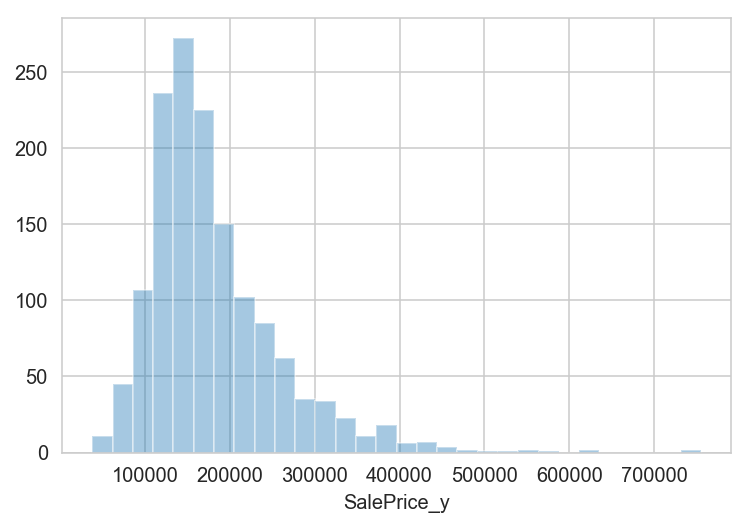

In [27]:
'''
As the distributions for sale price and lot area are right skewed I have decided to use a log scale for these features
'''

sns.distplot(ames['SalePrice_y'],bins=30, kde=False)


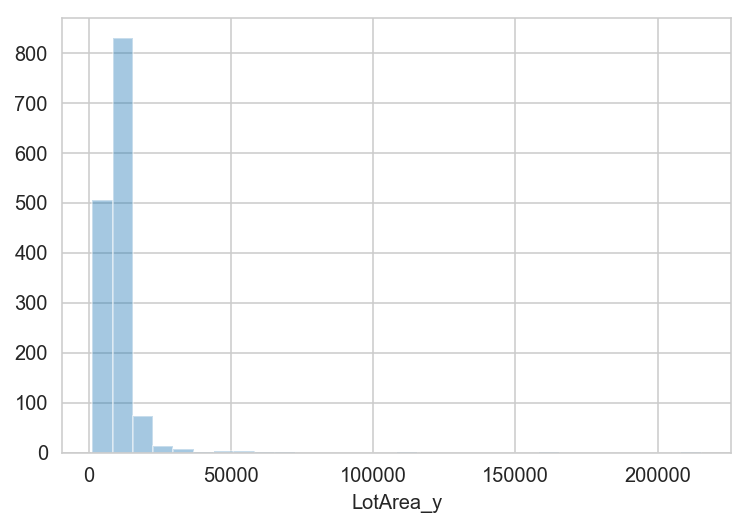

In [28]:
sns.distplot(ames['LotArea_y'],bins=30, kde=False)

In [29]:
ames['sales_price'] = np.log(ames['SalePrice_y'])
ames['lot_area'] = np.log(ames['LotArea_y'])


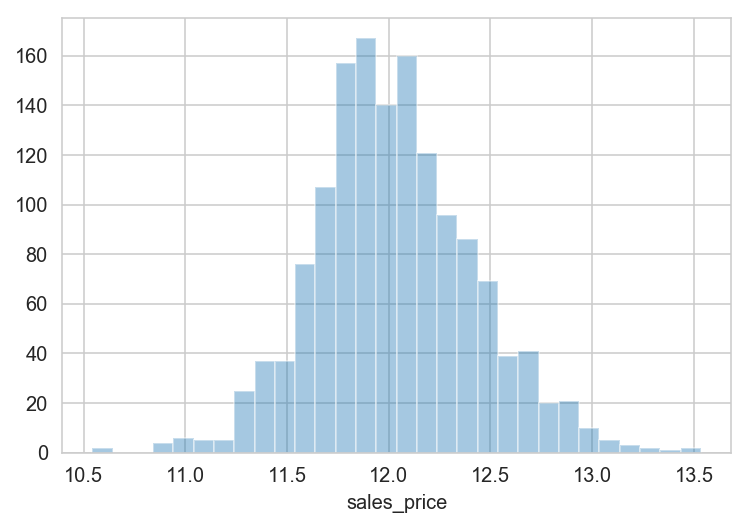

In [30]:
sns.distplot(ames['sales_price'],bins=30, kde=False)


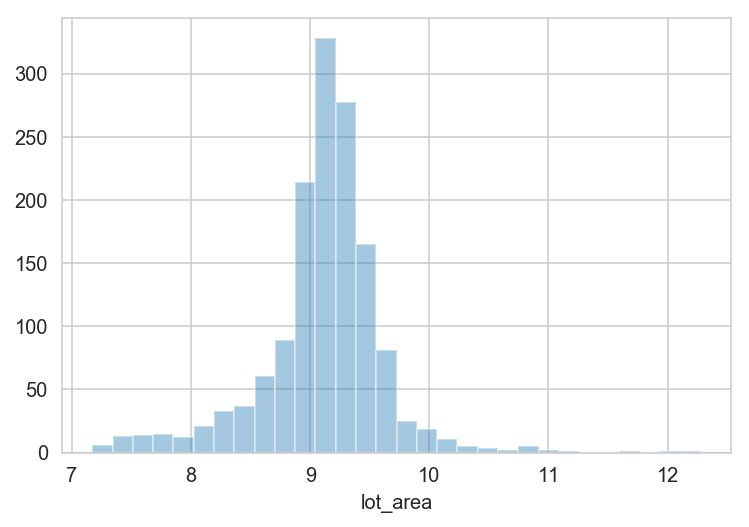

In [31]:
sns.distplot(ames['lot_area'],bins=30, kde=False)


In [32]:
'''
Here I remove the original sale price and lot area columns
'''

ames.drop(['SalePrice_y','LotArea_y'], axis=1, inplace=True)


In [33]:
'''
Confirm continuity of shape
'''

ames.shape


(1444, 69)

In [34]:
'''
Confirm what values are in the YrSold column for later test train split
'''

ames.YrSold.value_counts()


2009    334
2007    328
2006    313
2008    298
2010    171
Name: YrSold, dtype: int64

In [35]:
'''
Create new sub dataframe and create csv copy to use in question 3
'''

ames_edit = ames

In [36]:
ames_edit.to_csv('./ames_edit.csv')


In [37]:
'''
Here I am removing my test data from the dataset. Here I am creating a csv version of each to use in question 2
'''
test = ames[['sales_price', 'YrSold']].copy()
train = ames.drop(['sales_price'], axis=1)

train.to_csv('./train.csv')
test.to_csv('./test.csv')

In [38]:
'''
Here I am going to pull out the fixed variables to build the predictive model.
'''

fixed_var = ames[['Id', 'MSZoning', 'lot_area', 'LotShape', 'LotFrontage',
            'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BedroomAbvGr',
            'Condition2', 'BldgType', 'HouseStyle',   'YearBuilt', 'YearRemodAdd', 'Foundation', 
            'BsmtExposure', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 
            'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'FullBath', 'HalfBath',
            'TotRmsAbvGrd', 'MoSold_y', 'YrSold', 'SaleType', 'SaleCondition', 'Latitude', 'Longitude']].copy()


In [39]:
'''
For the training data, we will standarise the numerical data and dummify the categorical columns. First I pull out 
the numeric columns from the train set. We will also take this opportunity to view the correlation between the
variable selected.
'''

fixed_var_num = fixed_var.select_dtypes(include = 'number')


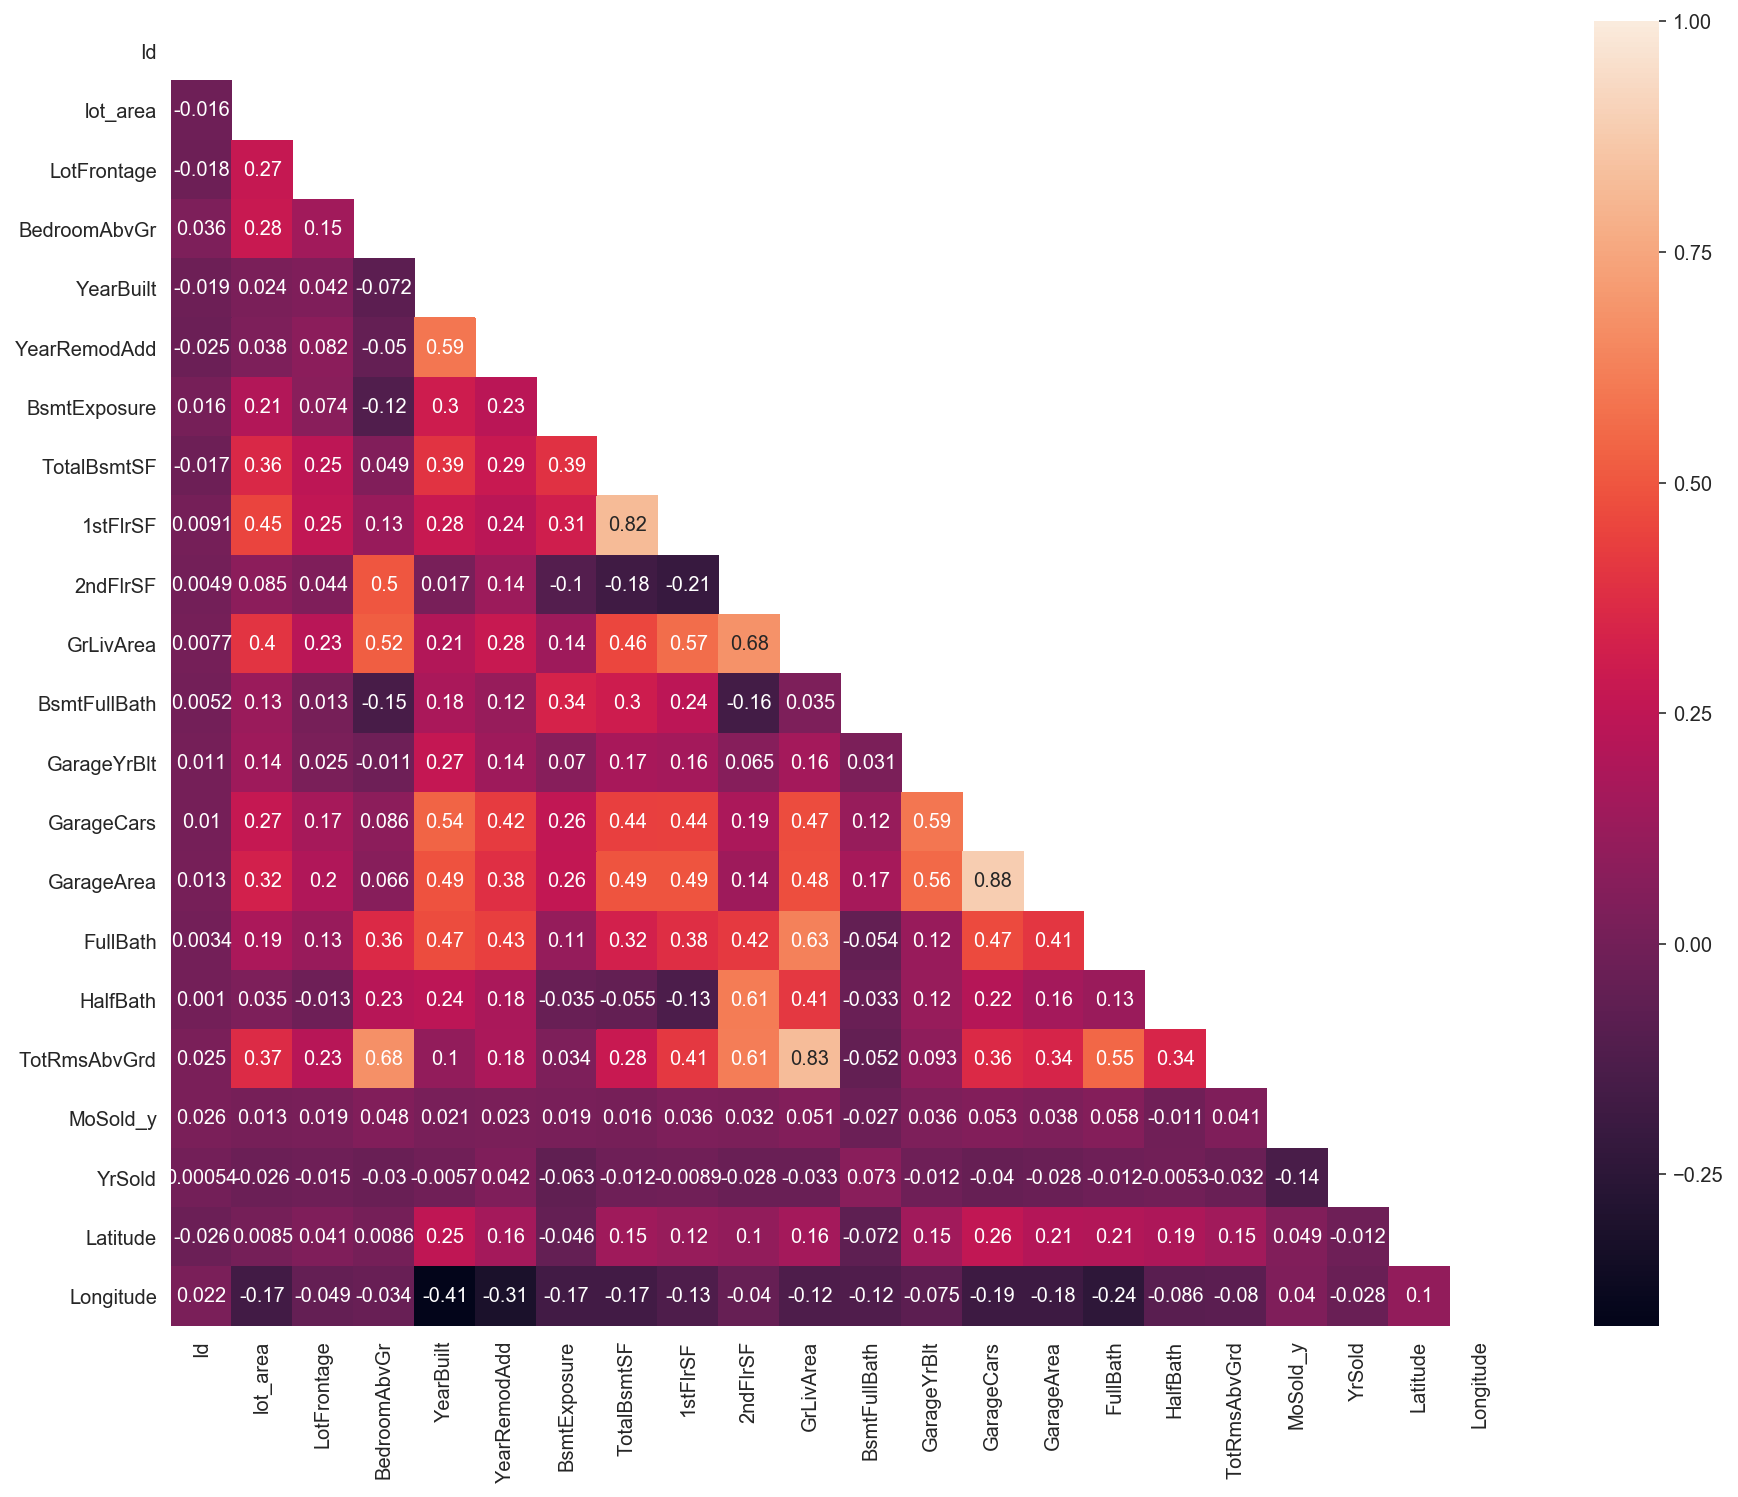

In [40]:
f, ax = plt.subplots(figsize=(15, 12))
corr = fixed_var_num.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, annot=True)

In [41]:
'''
Here, I confirm that all the columns that have been extracted are numerical in nature
'''

fixed_var_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444 entries, 0 to 1443
Data columns (total 22 columns):
Id              1444 non-null int64
lot_area        1444 non-null float64
LotFrontage     1444 non-null float64
BedroomAbvGr    1444 non-null int64
YearBuilt       1444 non-null int64
YearRemodAdd    1444 non-null int64
BsmtExposure    1444 non-null int64
TotalBsmtSF     1444 non-null int64
1stFlrSF        1444 non-null int64
2ndFlrSF        1444 non-null int64
GrLivArea       1444 non-null int64
BsmtFullBath    1444 non-null int64
GarageYrBlt     1444 non-null float64
GarageCars      1444 non-null int64
GarageArea      1444 non-null int64
FullBath        1444 non-null int64
HalfBath        1444 non-null int64
TotRmsAbvGrd    1444 non-null int64
MoSold_y        1444 non-null int64
YrSold          1444 non-null int64
Latitude        1444 non-null float64
Longitude       1444 non-null float64
dtypes: float64(5), int64(17)
memory usage: 248.3 KB


In [42]:
'''
All columns converted to float. This is to avoid warning in standard scaler
'''

fixed_var_num = fixed_var_num.astype(float)


In [43]:
'''
Split numerical columns into train and test based on year sold.
'''

fixed_num_train = fixed_var_num[fixed_var_num.YrSold != 2010]
fixed_num_test = fixed_var_num[fixed_var_num.YrSold == 2010]


In [44]:
'''
Drop numerical columns that don't make sense to be scaled
'''

fixed_num_train_std = fixed_num_train.drop(['Id','Latitude','Longitude','YrSold'], axis=1)
fixed_num_test_std = fixed_num_test.drop(['Id','Latitude','Longitude','YrSold'], axis=1)


In [45]:
'''
Here I create a sub dataframe for the lat, long and yrsold. We will use this to rebuild the dataframe after scaling.
'''

lat_long = fixed_var_num[['Latitude', 'Longitude', 'YrSold']].copy()


In [46]:
lat_long_train = lat_long[lat_long.YrSold != 2010]
lat_long_test = lat_long[lat_long.YrSold == 2010]


In [47]:
'''
Column names are stored, as after scaling they will be lost
'''

fixed_num_train_col = fixed_num_train_std.columns
fixed_num_test_col = fixed_num_test_std.columns


In [48]:
'''
Call standard scaler. Fit and transform training features, then just transform the test features. This makes sense
if you consider that if we were to fit on the test features then the two populations are not consistently
standardised
'''

ss=StandardScaler()


In [49]:
scaled_features_train = ss.fit_transform(fixed_num_train_std)
scaled_features_test = ss.transform(fixed_num_test_std)

In [50]:
'''
Store standardised feature in dataframes
'''

df1 = pd.DataFrame(scaled_features_train)
df2 = pd.DataFrame(scaled_features_test)


In [51]:
'''
Re-attach column names
'''

df1.columns = fixed_num_train_col
df2.columns = fixed_num_test_col

In [52]:
'''
Confirm that both dataframes have consistency in feature number
'''

print(df1.shape)
print(df2.shape)

(1273, 18)
(171, 18)


In [53]:
'''
Now select all object features from the fixed variable dataframe
'''

fixed_var_obj = fixed_var.select_dtypes(include = 'object')
fixed_var_obj.columns

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'Foundation', 'GarageType', 'SaleType', 'SaleCondition'],
      dtype='object')

In [54]:
'''
Dummy all categorical features. We do this as sklearn modelling requires all features to be numeric. Here I apply 
one hot encoding, then drop the first column to dummify, and store all values as floats
'''

fixed_var_obj = pd.get_dummies(fixed_var_obj, drop_first=True, dtype=float)

In [55]:
'''
Here I attach the YrSold column in order to be able to split the categorical variables into train and test. Then I 
split then and dropped the YrSold column
'''

fixed_var_obj = pd.concat([fixed_var_obj, fixed_var_num['YrSold']], axis=1)


In [56]:
df3 = fixed_var_obj[fixed_var_obj.YrSold != 2010]
df4 = fixed_var_obj[fixed_var_obj.YrSold == 2010]


In [57]:
df3 = df3.drop(['YrSold'], axis=1)
df4 = df4.drop(['YrSold'], axis=1)


In [58]:
'''
Again consistency of shape is observed
'''

print(df3.shape)
print(df4.shape)


(1273, 88)
(171, 88)


In [59]:
'''
Here I remerge all three X_train dataframes. I found that I needed to reset the index when I did this otherwise there
issues with how the columns aligned.
'''

X_train = pd.concat([df1.reset_index(drop=True), df3.reset_index(drop=True), lat_long_train.reset_index(drop=True)], axis=1)

In [60]:
'''
Confirm successful merge. No extra rows added
'''

X_train.shape

(1273, 109)

In [61]:
'''
Here I created a fixed columns dataframe, and moved it to csv for use in question 2
'''
fixed_col = pd.DataFrame(X_train.columns)

In [62]:
fixed_col.to_csv('./fixed_col.csv')

In [63]:
'''
Join all three of the y_train dataframes to create a singular test set
'''

y_train = pd.concat([df2.reset_index(drop=True), df4.reset_index(drop=True), lat_long_test.reset_index(drop=True)], axis=1)

In [64]:
y_train.shape

(171, 109)

In [65]:
'''
Here I separated the test set based on YrSold
'''

X_test = test[test.YrSold != 2010]
y_test = test[test.YrSold == 2010]


In [66]:
'''
Here I changed the label of test, just to help clarify things in my mind. Didn't need to do this, but made it clearer 
to me for a first time attempt
'''

X_train_label = X_test['sales_price']
y_train_label = y_test['sales_price']

In [67]:
'''
Confirm continuity of shape accross all dataframes
'''

print(X_train.shape)
print(y_train.shape)
print(X_train_label.shape)
print(y_train_label.shape)

(1273, 109)
(171, 109)
(1273,)
(171,)


In [68]:
'''
Calculate baseline for both test and train sets. It is important the the two means are similar to each other, 
otherwise it could indicate that they are representative of different populations
'''

np.mean(X_train_label)

12.03093903639083

In [69]:
np.mean(y_train_label)

12.017385828254582

In [70]:
'''
Now that we have our test and training data we can do some modelling. We are going to try linear regression. Here
we call in the linear regression package then fit it on the X data.
'''
lr = LinearRegression()
lr.fit(X_train, X_train_label)


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [71]:
'''
Here we score our model on the training data
'''

print(lr.score(X_train, X_train_label))

0.8789606388639102


In [72]:
'''
Here we score our model on our test data
'''

print(lr.score(y_train, y_train_label))

0.8861289492099192


In [73]:
'''
Here we apply cross validation to ensure no under or overfitting.
'''

scores = cross_val_score(lr, X_train, X_train_label, cv=10).mean()
print("Cross-validated scores:", scores)

Cross-validated scores: 0.8069186368066094


171


/Users/mbp15/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


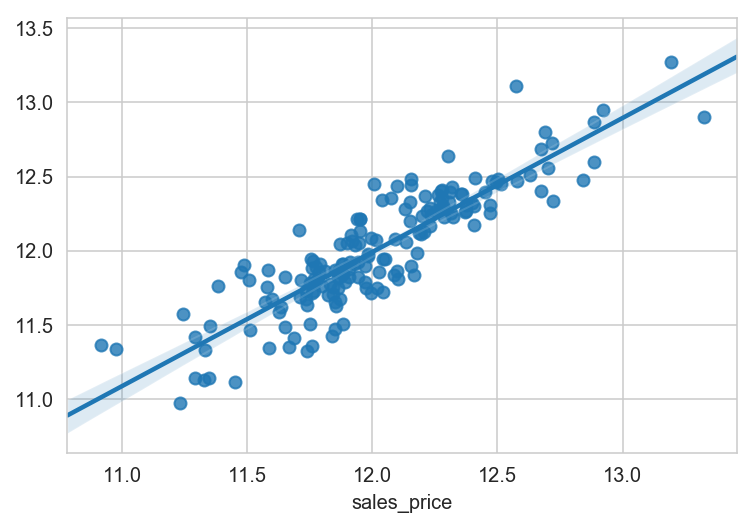

In [74]:
'''
Here I applied the predict function to visualise the variance in the model
'''

predictions = cross_val_predict(lr, y_train, y_train_label, cv=10)
print(len(predictions))
sns.regplot(y_train_label, predictions)

In [75]:
'''
Here I get the r2 score of the model
'''

r2 = metrics.r2_score(y_train_label, predictions)
print("Cross-Predicted R2:", r2)

Cross-Predicted R2: 0.7549777910198199


In [76]:
'''
After observing these score, I decided to do some regularisation. I ran the regularisation in Gridsearch in order
to optimise the hyperparameters as I was doing the regularisation. First I did Rigde, the Lasso, then ElasticNet.
'''

# prepare a range of alpha values to test
alphas = np.array([0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
# create and fit a ridge regression model, testing each alpha
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=10)
grid.fit(X_train, X_train_label)
ridge_score = grid.best_score_
ridge_best_est = grid.best_estimator_
ridge_best_params = grid.best_params_
ridge_coef = grid.best_estimator_.coef_
# print(grid)
# summarize the results of the grid search
print(ridge_score)
print(ridge_best_est.alpha)
print(ridge_best_params)
print(ridge_coef)


0.8292073101405455
10.0
{'alpha': 10.0}
[ 0.04644391 -0.01367156 -0.00329642  0.05241564  0.0535013   0.03217997
  0.03113821  0.03392861  0.05639825  0.08367714  0.03410687  0.0095559
  0.05575249 -0.00508937  0.01861332  0.01815896  0.01310966  0.00750366
 -0.01763766  0.00931466 -0.0397823   0.02788296 -0.07975255  0.00621772
  0.06094602 -0.02269406  0.04430523  0.02877778 -0.04019    -0.01214102
  0.00057675  0.01978844 -0.03672641  0.00657271  0.00754016  0.03111583
 -0.01476566 -0.04463549  0.12771631 -0.11275001 -0.07395007 -0.01472626
 -0.07517349 -0.08666708 -0.03228568  0.01461961 -0.02668057  0.06561927
  0.13992432 -0.04489827 -0.01043919 -0.06625083 -0.02078366  0.0674628
  0.12483233  0.00839797  0.04453843 -0.02161612  0.04178995  0.01552777
  0.01401221 -0.05466084  0.00569318  0.00258004  0.0350282   0.00504911
  0.08806308 -0.08025403 -0.00796847 -0.00336525  0.00369082 -0.02629261
 -0.09501655 -0.04144898 -0.02113052  0.03061999  0.00962523  0.0078333
  0.00623191 -

In [77]:
# prepare a range of alpha values to test
alphas = np.array([0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1])
# create and fit a ridge regression model, testing each alpha
model = Lasso()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas), cv=10)
grid.fit(X_train, X_train_label)
lasso_score = grid.best_score_
lasso_best_est = grid.best_estimator_
lasso_coef = grid.best_estimator_.coef_
lasso_predict_y = pd.DataFrame(grid.best_estimator_.predict(y_train))
# print(grid)
# summarize the results of the grid search
print(lasso_score)
print(lasso_best_est.alpha)
print(lasso_coef)
#print(lasso_predict_y)


0.8249546568506969
0.001
[ 0.04677864 -0.0116603  -0.          0.05574529  0.0546938   0.03251441
  0.03486037  0.          0.01020351  0.13098142  0.03150135  0.01172384
  0.05410511 -0.          0.01760158  0.01761212  0.00995045  0.00753951
 -0.          0.00374339 -0.04179022  0.         -0.05212405  0.
  0.0379062  -0.          0.02946832  0.01620563 -0.01334513 -0.
  0.          0.         -0.          0.          0.          0.03990555
 -0.         -0.0107901   0.16106755 -0.08354516 -0.03567291  0.
 -0.03567815 -0.05374854 -0.          0.         -0.          0.06980364
  0.15890571 -0.01400989 -0.         -0.02861653 -0.          0.07706329
  0.14994972  0.          0.         -0.00277848  0.04319633  0.
  0.         -0.          0.          0.          0.          0.
  0.0661531  -0.         -0.         -0.         -0.         -0.
 -0.1135952  -0.00475994 -0.          0.          0.         -0.
  0.         -0.03520427 -0.          0.          0.          0.02163198
 -0.00494

In [78]:
'''
Here I wanted to get the lasso predicted values for the whole dataset for use with something I was trying in question
2, in the end it started taking up too much time so I scrapped the idea.
'''

# lasso_predict_X = pd.DataFrame(grid.best_estimator_.predict(X_train))

In [79]:
# lasso_predict_X = pd.concat([lasso_predict_X.reset_index(drop=True), lat_long_train.reset_index(drop=True)], axis = 1)

In [81]:
# lasso_predict_y = pd.concat([lasso_predict_y.reset_index(drop=True), lat_long_test.reset_index(drop=True)], axis = 1)

In [83]:
# model_predicted = pd.concat([lasso_predict_y.reset_index(drop=True), lasso_predict_X.reset_index(drop=True)], axis = 0)

In [84]:
# model_predicted

,0,Latitude,Longitude,YrSold
0,11.904932,42.055171,-93.625651,2010.0
1,11.898679,42.030992,-93.676374,2010.0
2,11.780059,42.035544,-93.607586,2010.0
3,12.559229,42.061955,-93.655232,2010.0
4,11.996319,42.043101,-93.617693,2010.0
5,11.762076,42.039929,-93.618223,2010.0
6,12.452185,42.057652,-93.652738,2010.0
7,11.610940,42.028512,-93.624147,2010.0
8,12.466078,42.049236,-93.614645,2010.0
9,11.374934,42.034399,-93.615297,2010.0


In [97]:
# model_predicted['predict_sales_price'] = np.exp(model_predicted[0])

In [106]:
# model_predicted

,index,0,Latitude,Longitude,YrSold,predict_sales_price
0,0,11.904932,42.055171,-93.625651,2010.0,147994.674339
1,1,11.898679,42.030992,-93.676374,2010.0,147072.186103
2,2,11.780059,42.035544,-93.607586,2010.0,130621.454691
3,3,12.559229,42.061955,-93.655232,2010.0,284710.833419
4,4,11.996319,42.043101,-93.617693,2010.0,162156.869555
5,5,11.762076,42.039929,-93.618223,2010.0,128293.477001
6,6,12.452185,42.057652,-93.652738,2010.0,255808.548932
7,7,11.610940,42.028512,-93.624147,2010.0,110297.861320
8,8,12.466078,42.049236,-93.614645,2010.0,259387.351725
9,9,11.374934,42.034399,-93.615297,2010.0,87110.586916


In [107]:
# model_predicted.to_csv('./model_predicted.csv')

In [86]:
# prepare a range of alpha values to test
parameters = {'alpha': [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
              'l1_ratio': (0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1)}


# create and fit a ridge regression model, testing each alpha
model = ElasticNet()
grid = GridSearchCV(estimator=model, param_grid=parameters,cv=10)
grid.fit(X_train, X_train_label)
enet_score = grid.best_score_
enet_best_est = grid.best_estimator_
# print(grid)
# summarize the results of the grid search
print(enet_score)
print(enet_best_est.l1_ratio)
print(enet_best_est.alpha)


0.823040327390948
0.1
0.01


In [87]:
'''
As rigde returned the best results, I then did some further modelling with Ridge to obtain the new r2 score, then 
looked into how many variables the ridge regression removed and looked at the strengths of the co-efficients as well
'''

ridge = Ridge()
ridge.set_params(alpha = 10)


Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [88]:
ridge_best_est.fit(X_train, X_train_label)


Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [89]:
ridge_best_est.score(y_train, y_train_label)


0.891086514961032

In [90]:
sales_predict = ridge_best_est.predict(y_train)


/Users/mbp15/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


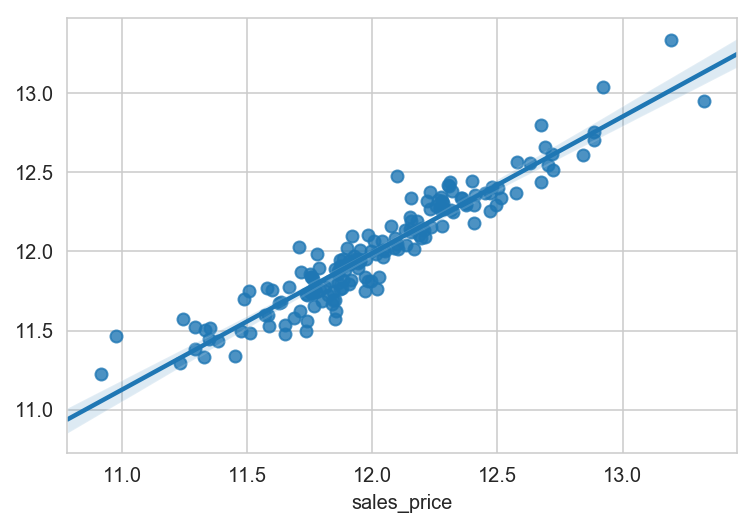

In [91]:
sns.regplot(y_train_label, sales_predict)


statsmodel, VIF, if VIF is greater than 5 then you can drop column.0

In [92]:
dfl = pd.DataFrame(data = lasso_coef, index = X_train.columns, columns=['coefs'])

dfl.reset_index()

dfl['feature'] = dfl.index

dfl.reset_index(drop=True)

dfl = dfl[dfl.coefs != 0]

dfl_sorted = dfl.sort_values(by=['coefs'], ascending=False)

dfl_sorted.set_index(['feature'], drop=True, inplace=True)

Lasso picked 49 features and eliminated the other 60 features


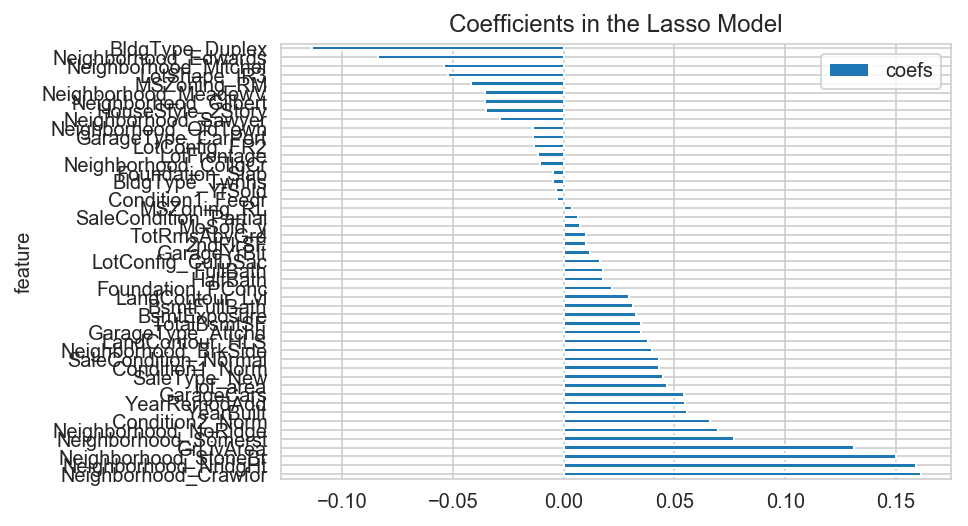

In [93]:
coefs = pd.Series(lasso_coef, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = dfl_sorted #pd.concat([df_reno_sorted.head(10),
                     #df_reno_sorted.tail(10)])
imp_coefs.plot(kind = "barh")

plt.rcParams["figure.figsize"] = (36,12)
plt.title("Coefficients in the Lasso Model")
plt.show()

In [94]:
dfr = pd.DataFrame(data = ridge_coef, index = X_train.columns, columns=['coefs'])

dfr.reset_index()

dfr['feature'] = dfr.index

dfr.reset_index(drop=True)

dfr = dfr[dfr.coefs != 0]

dfr.sort_values(by=['coefs'], ascending=False)

,coefs,feature
Neighborhood_NridgHt,0.139924,Neighborhood_NridgHt
Neighborhood_Crawfor,0.127716,Neighborhood_Crawfor
Neighborhood_StoneBr,0.124832,Neighborhood_StoneBr
Condition2_Norm,0.088063,Condition2_Norm
GrLivArea,0.083677,GrLivArea
Neighborhood_Somerst,0.067463,Neighborhood_Somerst
Neighborhood_NoRidge,0.065619,Neighborhood_NoRidge
LandContour_HLS,0.060946,LandContour_HLS
2ndFlrSF,0.056398,2ndFlrSF
GarageCars,0.055752,GarageCars


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: